# GLMS: Bias in admissions

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
from PIL import Image
from theano import shared
import arviz as az
from scipy.special import expit as logistic

In [2]:
def data_proc():
    
    def standardise(x):
        return (x-x.mean())/x.std()
    
    data = pd.read_csv(os.path.join(os.getcwd(),r'data/UCBadmit.csv'), delimiter=";")
    
    return data

#### On the surface this is a tiny dataset with 12 obs.  These are graduate school applications to 6 different academic departments at UC Berkeley.168 The admit column indicates the number offered admission. The reject column indicates the opposite decision. The applications column is just the sum of admit and reject. Each application has a 0 or 1 outcome for admission, but since these outcomes have been aggregated by department and gender, there are only 12 rows. These 12 rows however represent 4526 applications, the sum of the applications column. So there is a lot of data here—counting the rows in the data table is no longer a sensible way to assess sample size. We could split these data apart into 0/1 Bernoulli trials, like in the original chimpanzees data. Then there would be 4526 rows in the data.


#### Objective: evaluate whether these data contain evidence of gender bias in admissions. We will model the admission decisions, focusing on applicant gender as a predictor variable. So we want to fit a binomial regression that models admit as a function of each applicant’s gender. This will estimate the association between gender and probability of admission

$$ A_{i} \sim Binomial(N_{i}, p_{i})$$
$$logit(p_{i}) = \alpha_{GID[i]}$$
$$\alpha_{i} \sim Normal(0, 1.5)$$

#### $N_{i}$ indicates applications $i$, the number of applications on the $ith$ row. The index variable $GID[i]$ indexes the gender of an applicant. 

In [3]:
data = data_proc()

In [4]:
data

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


In [5]:
gid = (data["applicant.gender"]=="female").astype(int).values

In [6]:
with pm.Model() as m11_7:
    a = pm.Normal("a", 0, 1.5, shape=2)
    p = pm.Deterministic("p", pm.math.invlogit(a[gid]))
    
    admit = pm.Binomial("admit", p=p, n=data.applications, observed=data.admit)
    
    trace_11_7 = pm.sample(random_seed = 8_927)

<ipython-input-6-40a5db506968>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_11_7 = pm.sample(random_seed = 8_927)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [7]:
pm.summary(trace_11_7, var_names=["a"])

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.220,0.040,-0.291,-0.143,0.001,0.000,3727.0,2902.0,1.0
a[1],-0.831,0.052,-0.928,-0.736,0.001,0.001,3851.0,2833.0,1.0


#### The posterior mean is higher for males than females, how much higher? We need to compute the contrast.

In [8]:
diff_a = trace_11_7["a"][:, 0] - trace_11_7["a"][:, 1]
diff_p = logistic(trace_11_7["a"][:, 0] - trace_11_7["a"][:, 1])

az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats")

,mean,sd,hdi_3%,hdi_97%
diff_a,0.611,0.067,0.479,0.728
diff_p,0.648,0.015,0.617,0.674


#### The log-odds difference is certainly positive, corresponding to a higher probability of admission for male applicants. On the probability scale itself, the difference is somewhere between 12% and 16%.

### Posterior predictions

In [9]:
with m11_7:
    ppc = pm.sample_posterior_predictive(trace_11_7, random_seed=8_927, var_names=["admit"])["admit"]

In [10]:
pp_admit = ppc/ data.applications.values[None, :]

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


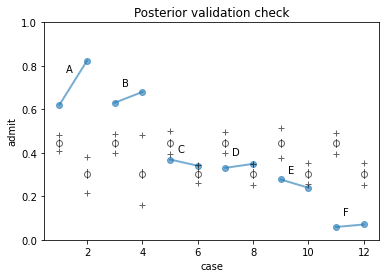

In [11]:
for i in range(6):
    x = 1 + 2 * i
    
    y1 = data.admit[x] / data.applications[x]
    y2 = data.admit[x + 1] / data.applications[x + 1]
    
    plt.plot([x, x+1], [y1, y2], "-C0o", alpha=0.6, lw=2)
    plt.text(x + 0.25, (y1 + y2)/2+0.05, data.dept[x])

plt.plot(range(1, 13), trace_11_7["p"].mean(0), "ko", fillstyle="none", ms=6, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hdi(trace_11_7["p"]).T, "k-", lw=1, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hdi(pp_admit).T, "k+", ms=6, alpha=0.6)

plt.xlabel("case")
plt.ylabel("admit")
plt.title("Posterior validation check")
plt.ylim(0, 1);

#### There are only two departments in which females had a lower rate of admission than males (C and E), and yet the model says that females should expect to have a 14% lower chance of admission.

#### The model did correctly answer the question we asked of it: What are the average probabilities of admission for females and males, across all departments? The problem in this case is that males and females do not apply to the same departments, and departments vary in their rates of admission. This makes the answer misleading. You can see the steady decline in admission probability for both males and females from department A to department F. Females in these data tended not to apply to departments like A and B, which had high overall admission rates. Instead they applied in large numbers to departments like F, which admitted less than 10% of applicants. So while it is true overall that females had a lower probability of admission in these data, it is clearly not true within most departments. And note that just inspecting the posterior distribution alone would never have revealed that fact to us. We had to appeal to something outside the fit model. In this case, it was a simple posterior validation check.


#### Instead of asking “What are the average probabilities of admission for females and males across all departments?” we want to ask “What is the average difference in probability of admission between females and males within departments?” In order to ask the second question, we estimate unique female and male admission rates in each department.

#### The model now is:


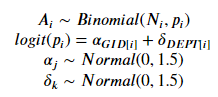

In [12]:
display(Image.open(os.path.join(os.getcwd(),r'data/admissions_model.png')))

#### Where dept indexes department in $k = 1,...,6$, so each dept now gets its own log-odds of admission $\delta_{k}$ but the model still estimates universal adjustments (the same in all departments) for male and female applications.

In [13]:
dept_id = pd.Categorical(data["dept"]).codes

with pm.Model() as m11_8:
    a = pm.Normal("a", 0, 1.5, shape=2)
    delta = pm.Normal("delta", 0, 1.5, shape=6)
    
    p = pm.math.invlogit(a[gid] + delta[dept_id])
    
    admit = pm.Binomial("admit", p=p, n=data.applications, observed=data.admit)
    
    trace_11_8 = pm.sample(2_000, random_seed = 8_927)

az.summary(trace_11_8)

<ipython-input-13-d8c354cb0c5d>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_11_8 = pm.sample(2_000, random_seed = 8_927)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
The number of effective samples is smaller than 10% for some parameters.
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.518,0.558,-1.563,0.520,0.02,0.014,796.0,871.0,1.0
a[1],-0.421,0.558,-1.446,0.634,0.02,0.014,794.0,880.0,1.0
delta[0],1.100,0.560,0.064,2.171,0.02,0.014,799.0,870.0,1.0
delta[1],1.054,0.562,-0.001,2.105,0.02,0.014,814.0,914.0,1.0
delta[2],-0.161,0.560,-1.226,0.867,0.02,0.017,795.0,888.0,1.0
delta[3],-0.193,0.560,-1.286,0.818,0.02,0.016,797.0,877.0,1.0
delta[4],-0.636,0.563,-1.713,0.403,0.02,0.015,813.0,951.0,1.0
delta[5],-2.191,0.569,-3.216,-1.079,0.02,0.014,834.0,944.0,1.0


#### The intercept for male applicants a[0] is now a little smaller on average than the one for female applicants. Let's derive the relative and absolute contrasts.

In [14]:
diff_a = trace_11_8["a"][:, 0] - trace_11_8["a"][:, 1]
diff_p = logistic(trace_11_8["a"][:, 0]) - logistic(trace_11_8["a"][:, 1])
az.summary({"diff_a": diff_a, "diff_p": diff_p})

arviz - WARNING - Shape validation failed: input_shape: (1, 8000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
diff_a,-0.097,0.081,-0.258,0.043,0.001,0.001,8996.0,7267.0,NaN
diff_p,-0.022,0.018,-0.056,0.013,0.000,0.000,7888.0,7370.0,NaN


#### If male applicants have it worse, it is only by a very small amount, about 2% on average. Why did adding departments to the model change the inference about gender so much? The earlier figure gives you a hint—the rates of admission vary a lot across departments. Furthermore, females and males tend to apply to different departments.

In [15]:
data

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


In [16]:
depts = ["A", "B", "C", "D", "E", "F"]

In [17]:
print("     Male", "        Female")
for i in depts:
    print(i,(data.loc[data.dept==i, "applications"]/np.sum(data.loc[data.dept==i, "applications"])).values)

     Male         Female
A [0.88424437 0.11575563]
B [0.95726496 0.04273504]
C [0.3540305 0.6459695]
D [0.52651515 0.47348485]
E [0.32705479 0.67294521]
F [0.52240896 0.47759104]


#### These are the proportions of all applications in each department that are either male (top row) or female (bottom row). Department A receives 88% of its applications from males. Department E receives 33% from males. Now look back at the delta posterior means in the output from m11.8. The departments with a larger proportion of female applicantsare also those with lower overall admissions rates.

#### Department is probably a confound, in the sense that it misleads us about the direct causal effect. But it is not a confound, in the sense that it is probably a genuine causal path through gender influences admission. Gender influences choice of department, and department influences chance of admission. Controlling for department reveals a more plausible direct causal influence of gender.

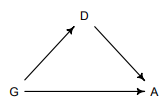

In [18]:
display(Image.open(os.path.join(os.getcwd(),r'data/admissions_dag_1.png')))

#### Where D is department, G is gender and A is acceptance. There is an indirect causal path G ---> D ---> A, so to infer the direct effect G ---> A we need to condition on D and close the indirect path, this is achieved in model m11_8.

#### What if there are unobserved confounds influencing both dept and admissions?

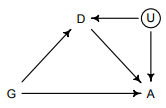

In [19]:
display(Image.open(os.path.join(os.getcwd(),r'data/admissions_dag_2.png')))

#### U could be academic ability which influences the choice of dept and probability of admission, in which case conditioning on dept is conditioning on a collider and it opens up a non-causal path between gender and admissions. G ---> D <--- U ----> A.

#### Equivalently we could use a Poisson model since we can refactor a categorical model into a series of Poisson models.

In [21]:
#first model overall admission probability with the binom model
with pm.Model() as admit_binom:
    a = pm.Normal("a", 0, 1.5)
    p = pm.math.invlogit(a)
    
    admit = pm.Binomial("admit", p=p, n=data.applications, observed=data.admit)
    
    trace_binom = pm.sample(1_000, tune=2_000)

<ipython-input-21-e91cfe376759>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_binom = pm.sample(1_000, tune=2_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


In [22]:
# Then fit poisson model of overall admissions and rejection rates

with pm.Model() as admit_pois:
    a = pm.Normal("a", 0, 1.5, shape=2)
    lam = pm.math.exp(a)
    
    admit = pm.Poisson("admit", lam[0], observed=data.admit)
    reject = pm.Poisson("reject", lam[1], observed=data.reject)

    trace_pois = pm.sample(1_000, tune=2_000)
    
    

<ipython-input-22-10b8164f0ed0>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_pois = pm.sample(1_000, tune=2_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.


In [24]:
az.summary(trace_binom)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.457,0.03,-0.517,-0.403,0.001,0.001,1735.0,2700.0,1.0


In [29]:
m_binom = az.summary(trace_binom)
print(f'The binomial probability of admission is: {logistic(m_binom["mean"])[0]}')

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


The binomial probability of admission is: 0.3876977480872859


#### The Poisson probability of admission is given by:
$$P_{admit} = \lambda_{1}/(\lambda_{1} + \lambda_{2}) = exp(a_{1}) / (exp(a_{1}) + exp(a_{2}))$$

In [30]:
az.summary(trace_pois)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],4.984,0.024,4.940,5.029,0.0,0.0,3093.0,2705.0,1.0
a[1],5.441,0.019,5.407,5.475,0.0,0.0,3365.0,2719.0,1.0


In [31]:
m_pois = az.summary(trace_pois)
pois_prob = np.exp(m_pois["mean"][0])/(np.exp(m_pois["mean"][0]) + np.exp(m_pois["mean"][1]))
print(f'The poisson probability of admission is: {pois_prob}')


/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


The poisson probability of admission is: 0.3876977480872859
